#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
df_stock1 = pd.read_csv("../static/data/nab.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,22.164883,22.164883,22.164883,22.164883,6.412319,0.0
1,4/01/2000,21.869984,21.879498,21.308727,21.403856,6.192155,3005390.0
2,5/01/2000,20.918701,21.099445,20.785522,20.975779,6.068309,4604126.0
3,6/01/2000,21.207891,21.213600,20.642830,20.642830,5.971987,2574906.0
4,7/01/2000,20.737959,20.880651,20.623804,20.823574,6.024276,3028993.0


<AxesSubplot:>

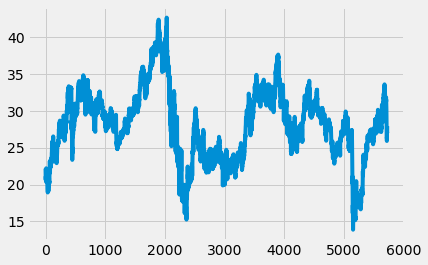

In [29]:
df["Close"].plot()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5692 entries, 0 to 5724
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5692 non-null   object 
 1   Open       5692 non-null   float64
 2   High       5692 non-null   float64
 3   Low        5692 non-null   float64
 4   Close      5692 non-null   float64
 5   Adj Close  5692 non-null   float64
 6   Volume     5692 non-null   float64
dtypes: float64(6), object(1)
memory usage: 355.8+ KB


In [31]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5692, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [32]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4554, 1)

In [33]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.28791442, 0.26146737, 0.24659094, 0.23502037, 0.24130154,
       0.25154974, 0.23832627, 0.23270628, 0.22609451, 0.2418305 ,
       0.2783273 , 0.28956731, 0.27634378, 0.26232689, 0.24692153,
       0.26807911, 0.25419445, 0.25419445, 0.23802872, 0.2502274 ,
       0.23935106, 0.23766508, 0.24394619, 0.23164837, 0.23601218,
       0.24163217, 0.23832627, 0.24229329, 0.23964864, 0.23402862,
       0.2217969 , 0.2211688 , 0.2049369 , 0.19663915, 0.19204396,
       0.18708515, 0.17981223, 0.17551465, 0.17848986, 0.20496995,
       0.20526749, 0.22510273, 0.24844223, 0.25396308, 0.22649124,
       0.21022626, 0.22311917, 0.20625924, 0.18146513, 0.19138277,
       0.18410988, 0.19733342, 0.20526749, 0.21518516, 0.20625924,
       0.20715184, 0.21981334, 0.23733445, 0.23832627, 0.24179742])]
[0.22344979789408392]


# Prepare train data for LSTM model

In [34]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4494, 60)

In [35]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4494, 60, 1)

# Build the LSTM model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4494/4494 [==============================] - 74s 16ms/step - loss: 0.0013


In [39]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [40]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [41]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [42]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.32984473146580057

C:\Users\antoi\AppData\Local\Temp/ipykernel_28068/1559395553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


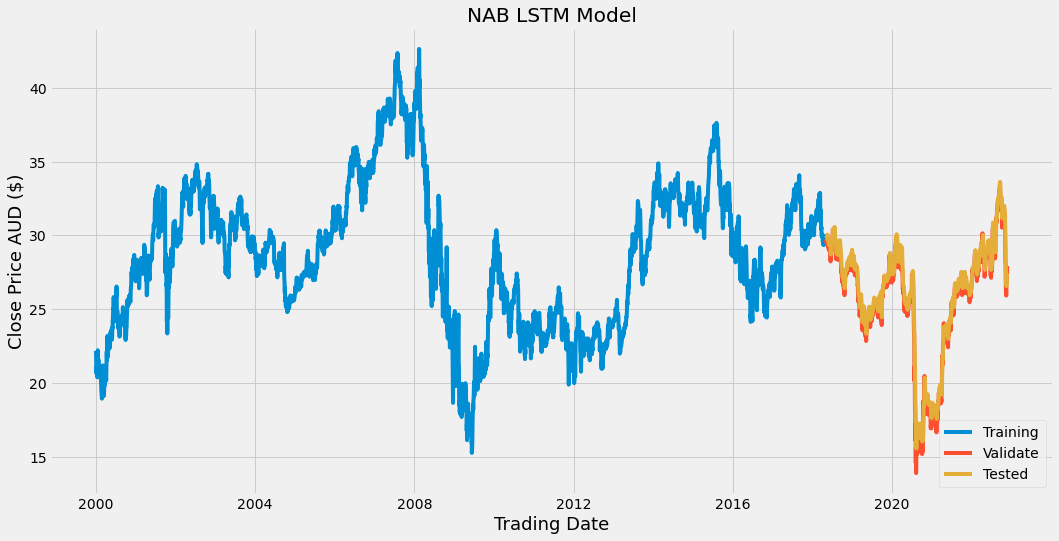

In [43]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NAB LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_graph.png')
plt.show()


# Test data Predictions on the Model

In [44]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_28068/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4587,29.559999,29.814142,-0.254143
4588,29.650000,29.811712,-0.161712
4589,29.570000,29.863295,-0.293295
4590,29.570000,29.856997,-0.286997
4591,29.480000,29.845745,-0.365745
...,...,...,...
5720,27.049999,26.565836,0.484163
5721,26.990000,27.017088,-0.027088
5722,27.129999,27.302197,-0.172198
5723,27.020000,27.479233,-0.459233


In [ ]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB
db.nab.drop()

import csv
header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
csvfile = open('../static/data/nab.csv', 'r')
reader = csv.DictReader( csvfile )

for each in reader:
    row={}
    for field in header:
        row[field]=each[field]
        
    print (row)
    db.nab.insert_one(row)	

In [45]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'NAB.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [95]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [47]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [48]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 27


In [49]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5725,28/06/2022,28.02,28.049999,27.559999,27.790001,27.790001,4190622.0,NEGATIVE,0.85,1.75


In [96]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
print(actual_price,actual_date)


27 28/06/2022


# Save the Model

In [51]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nab_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list cba_sixty and load df

#PREDICT USING LOADED MODEL

In [77]:
from keras.models import load_model

In [78]:
model_in = load_model('../static/nab_model.sav')

In [80]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file

nabdump_sixty = pd.read_csv("../static/data/nab.csv")
nabdump_sixty = nabdump_sixty.dropna()
nabdump_sixty = nabdump_sixty.iloc[-4250:]
sixty_val = nabdump_sixty.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 100 #days
if input == "":
    input = 100
else:
   input = int(input)

def predict_nab(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [81]:
predict_nab(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [82]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [83]:
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_28068/2919172947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1, 'Date': '29/06/2022', 'DOW': 'Wednesday', 'Price': 27.84},
 {'Count': 2, 'Date': '30/06/2022', 'DOW': 'Thursday', 'Price': 27.94},
 {'Count': 3, 'Date': '1/07/2022', 'DOW': 'Friday', 'Price': 28.01},
 {'Count': 4, 'Date': '2/07/2022', 'DOW': 'Monday', 'Price': 28.07},
 {'Count': 5, 'Date': '3/07/2022', 'DOW': 'Tuesday', 'Price': 28.12},
 {'Count': 6, 'Date': '4/07/2022', 'DOW': 'Wednesday', 'Price': 28.16},
 {'Count': 7, 'Date': '5/07/2022', 'DOW': 'Thursday', 'Price': 28.21},
 {'Count': 8, 'Date': '6/07/2022', 'DOW': 'Friday', 'Price': 28.25},
 {'Count': 9, 'Date': '7/07/2022', 'DOW': 'Monday', 'Price': 28.29},
 {'Count': 10, 'Date': '8/07/2022', 'DOW': 'Tuesday', 'Price': 28.33},
 {'Count': 11, 'Date': '9/07/2022', 'DOW': 'Wednesday', 'Price': 28.37},
 {'Count': 12, 'Date': '10/07/2022', 'DOW': 'Thursday', 'Price': 28.41},
 {'Count': 13, 'Date': '11/07/2022', 'DOW': 'Friday', 'Price': 28.45},
 {'Count': 14, 'Date': '12/07/2022', 'DOW': 'Monday', 'Price': 28.49},
 {'Coun

In [84]:
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 27.84},
 {'Price': 27.94},
 {'Price': 28.01},
 {'Price': 28.07},
 {'Price': 28.12},
 {'Price': 28.16},
 {'Price': 28.21},
 {'Price': 28.25},
 {'Price': 28.29},
 {'Price': 28.33},
 {'Price': 28.37},
 {'Price': 28.41},
 {'Price': 28.45},
 {'Price': 28.49},
 {'Price': 28.52},
 {'Price': 28.55},
 {'Price': 28.58},
 {'Price': 28.61},
 {'Price': 28.64},
 {'Price': 28.66},
 {'Price': 28.69},
 {'Price': 28.72},
 {'Price': 28.74},
 {'Price': 28.77},
 {'Price': 28.79},
 {'Price': 28.81},
 {'Price': 28.84},
 {'Price': 28.86},
 {'Price': 28.88},
 {'Price': 28.91},
 {'Price': 28.93},
 {'Price': 28.95},
 {'Price': 28.98},
 {'Price': 29.0},
 {'Price': 29.03},
 {'Price': 29.05},
 {'Price': 29.07},
 {'Price': 29.1},
 {'Price': 29.12},
 {'Price': 29.15},
 {'Price': 29.17},
 {'Price': 29.19},
 {'Price': 29.21},
 {'Price': 29.23},
 {'Price': 29.25},
 {'Price': 29.26},
 {'Price': 29.28},
 {'Price': 29.29},
 {'Price': 29.31},
 {'Price': 29.33},
 {'Price': 29.35},
 {'Price': 29.36},
 {'Price': 29.

In [85]:
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4554 5692 5792


,Close
5781,29.59
5782,29.60
5783,29.60
5784,29.60
5785,29.60
5786,29.61
5787,29.61
5788,29.61
5789,29.62
5790,29.62


C:\Users\antoi\AppData\Local\Temp/ipykernel_28068/2154112330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


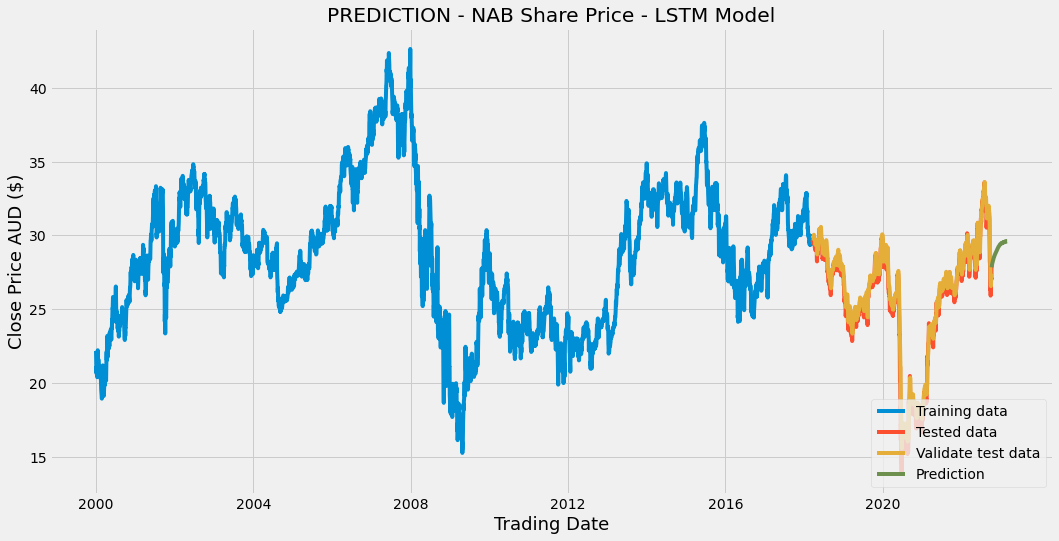

In [86]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION - NAB Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_predict_graph.png')
plt.show()

#Save predicted error to MongoDB

In [87]:
# Module used to connect Python with MongoDb
import pymongo

In [88]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [89]:
# Query all
companys = db.find()
# Iterate through each company in the collection
for company in companys:
    print(company)

# Here, db.companys refers to the collection 'companys '
# company_nab = db.find_one({'name': 'NAB'})
# print(company_nab)


{'_id': ObjectId('6265035484c61b8b6157cf4f'), 'model': 'LSTM', 'name': 'WBC', 'date': '20/04/2022', 'predicted': 24, 'actual': 24, 'differece': 0}
{'_id': ObjectId('62bbaebc940901ee4c7522f2'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 41, 'actual': 42, 'differece': -1, 'rmse': 0.53768}
{'_id': ObjectId('62bbb5d8d8978fe40ad3d64c'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 91, 'actual': 93, 'differece': -2, 'rmse': 0.33103}
{'_id': ObjectId('62bbc4728f600c8c92330dab'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 248, 'actual': 274, 'differece': -26, 'rmse': 16.33896}
{'_id': ObjectId('62bbc757193d5e9ca1048e29'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}


In [90]:
# Delete a document from a collection
db.delete_one(
    {'name': 'NAB'}
)

# query the companys collection
companys = db.find()
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('6265035484c61b8b6157cf4f'), 'model': 'LSTM', 'name': 'WBC', 'date': '20/04/2022', 'predicted': 24, 'actual': 24, 'differece': 0}
{'_id': ObjectId('62bbaebc940901ee4c7522f2'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 41, 'actual': 42, 'differece': -1, 'rmse': 0.53768}
{'_id': ObjectId('62bbb5d8d8978fe40ad3d64c'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 91, 'actual': 93, 'differece': -2, 'rmse': 0.33103}
{'_id': ObjectId('62bbc4728f600c8c92330dab'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 248, 'actual': 274, 'differece': -26, 'rmse': 16.33896}


In [91]:
# Set keys and values of company
name = 'NAB'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, rmse {round(rmse,5)}')

date 28/06/2022,predicted 27,actual 27, difference 0, rmse 0.32984


In [92]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference,
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('6265035484c61b8b6157cf4f'), 'model': 'LSTM', 'name': 'WBC', 'date': '20/04/2022', 'predicted': 24, 'actual': 24, 'differece': 0}
{'_id': ObjectId('62bbaebc940901ee4c7522f2'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 41, 'actual': 42, 'differece': -1, 'rmse': 0.53768}
{'_id': ObjectId('62bbb5d8d8978fe40ad3d64c'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 91, 'actual': 93, 'differece': -2, 'rmse': 0.33103}
{'_id': ObjectId('62bbc4728f600c8c92330dab'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 248, 'actual': 274, 'differece': -26, 'rmse': 16.33896}
{'_id': ObjectId('62bbc7cb193d5e9ca1048e2b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}


In [94]:
# # query the collection
# nabs = db.nab.find()

# # see change in collection
# for nab in nabs:
#     print(nab)